In [1]:
import csv
import numpy as np
import logging
import matplotlib.pyplot as plt
from imp import reload
reload(logging)

<module 'logging' from 'D:\\Anaconda3\\lib\\logging\\__init__.py'>

# Anomaly Detection by Using Global Statistics
We have seen that the moving average method is not very reliable when it has seen very few transactions. Thus we can try to fall back on global statistics for all customers. The method I'm using here is described as follows:
- For each individual account, if we have only seen less than 3 transactions under this account before the current transaction, we try to differentiate anomalies by not only comparing its deviation from the mean of the account, but also compare its deviation from the global mean. If $-3\times std_{global}<amount-mean_{global}<3\times std_{global}$ or $-3\times std_{account}<amount-mean_{account}<3\times std_{account}$, this transaction is recorded as normal.

- When there are already more than 3 transactions for the current account, we rely only on the statistics of the account and ignore global statistics as we assume that we have accumulated enough information of the account.

In [2]:
%%capture 

reload(logging)
logging.basicConfig(filename='anomaly_global_final.log', filemode='w', level=logging.DEBUG)
with open('task_data_small.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    merchant_dict = {} # store the merchant ID under each account
    amount_dict = {} # store the transaction amount for corresponding merchant ID under each account
    mean_dict = {} # store the moving average under each account
    std_dict = {} # store the moving standard deviation under each account
    anomaly_dict = {} # store the index of anomaly transactions under each account
    account_count_dict = {} # count the number of uncorrupted transactions under rach account
    mean_global = 0
    std_global = 0
    amount_global = [] # store the uncorrupted transactions for all customers
    
    anomaly_count = 0 # count the total number of anomalies
    
    for row in csv_reader:
        print("====================")
        
        # first ensure only the data that is not corrupted is processed
        if len(row)==3 and row[0]!='' and row[1]!='' and row[2]!='' and row[0]!='X' and row[1]!='X' and row[2]!='X': 
            account = row[0].strip() # account ID
            merchant = row[1].strip() # merchant ID
            amount = float(row[2]) # transaction amount
            print("Account: "+account)
            print("Merchant: "+merchant)
            print("Transaction amount: "+row[2])
            
            # obtain the global statistics
            amount_global.append(amount)
            mean_global = np.mean(amount_global)
            std_global = np.std(amount_global)
            
            # current account appeared before
            if account in merchant_dict:
                current_mean = mean_dict[account][-1]
                current_std = std_dict[account][-1]
                diff = amount - current_mean
                diff_global = amount - mean_global
                
                account_count_dict[account] += 1
                
                merchant_dict[account].append(merchant)
                amount_dict[account].append(amount)
                new_mean = np.mean(amount_dict[account])
                new_std = np.std(amount_dict[account])
                mean_dict[account].append(new_mean)
                std_dict[account].append(new_std)
                print("Mean of transaction amount so far: "+str(new_mean))
                print("Std of transaction amount so far: "+str(new_std))
                
                # if there are in total less than 3 transactions globally
                if len(amount_global)<=2:
                    print("Status: normal")
                
                # if there are less than 4 transactions (including the current transaction) for this account
                elif len(amount_dict[account])<=3:
                    if (diff>=-3*current_std and diff<=3*current_std)or(diff_global>=-3*std_global and diff_global<=3*std_global):
                        print("Status: normal")
                    else:
                        anomaly_count += 1
                        if account in anomaly_dict:
                            anomaly_dict[account].append(account_count_dict[account])
                        else:
                            anomaly_dict[account]=[account_count_dict[account]]

                        logging.warning('Flag: '+'account: '+account+' merchant: '+merchant+' amount: '+str(amount))
                        print("Status: abnormal. The event has been recorded in log file.")
                
                # if there are more than 3 transactions (including the current transaction) for this account
                else:
                    if diff>=-3*current_std and diff<=3*current_std:
                        print("Status: normal")
                    else:
                        anomaly_count += 1
                        if account in anomaly_dict:
                            anomaly_dict[account].append(account_count_dict[account])
                        else:
                            anomaly_dict[account]=[account_count_dict[account]]
                            
                        logging.warning('Flag: '+'account: '+account+' merchant: '+merchant+' amount: '+str(amount))
                        print("Status: abnormal. The event has been recorded in log file.")
                    
            # first time seeing the current account
            else:
                print("Mean of transaction amount so far: "+str(amount))
                print("Std of transaction amount so far: 0")
        
                merchant_dict[account] = [merchant]
                amount_dict[account] = [amount]
                mean_dict[account] = [amount]
                std_dict[account] = [0]
                diff_global = amount - mean_global
                
                account_count_dict[account]=0
                
                if len(amount_global)<=2:
                    print("Status: normal")
                elif diff_global>=-3*std_global and diff_global<=3*std_global:
                    print("Status: normal")
                else:
                    anomaly_count += 1
                    if account in anomaly_dict:
                        anomaly_dict[account].append(account_count_dict[account])
                    else:
                        anomaly_dict[account]=[account_count_dict[account]]

                    logging.warning('Flag: '+'account: '+account+' merchant: '+merchant+' amount: '+str(amount))
                    print("Status: abnormal. The event has been recorded in log file.")
                    
        # corrupted data
        else:
            account = row[0].strip() # account ID
            merchant = row[1].strip() # merchant ID
            print("Account: "+account)
            print("Merchant: "+merchant)
            print('The data of this transaction is corrupted' )

# Analysis
After using global statistics, we can see a clear drop in the number of anomalies recorded. This is mainly because we have considered global statistics when there are few transactions for an account, in this way we avoid marking a transaction as anomalous at a very early stage when they are actually resonable purchases when looked from a long-term perspective.

For instance, if we look at account 255046487 again in the graph below, the 3rd transaction is no longer marked as anomalous because of global data is considered. However, we are still facing the same problem that we faced when using moving average method for each individual account, that is anomalous data can affect the trend because they are averaged into the trend.

In [3]:
print('There are '+str(anomaly_count)+' anomalies recorded.') # number of anomalies recorded

There are 12092 anomalies recorded.


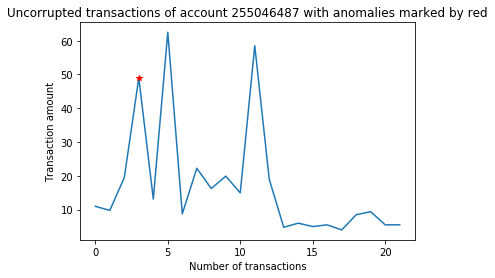

In [16]:
account = '255046487'
plt.plot(amount_dict[account]) # print all the transactions 
plt.title('Uncorrupted transactions of account '+account+' with anomalies marked by red')
plt.xlabel('Number of transactions')
plt.ylabel('Transaction amount')
if account in anomaly_dict: # if the account has anomalies, mark them by red points
    for i in range(len(anomaly_dict[account])):
        plt.plot(anomaly_dict[account][i], amount_dict[account][anomaly_dict[account][i]], 'r*')

To further illustrate the effect of using global statistics, we can look at the graph for account 110901576. If you check the graph for this same account without using the global statistics (in the 'anomaly_average' notebook), it can be seen the graph here is more reasonable.

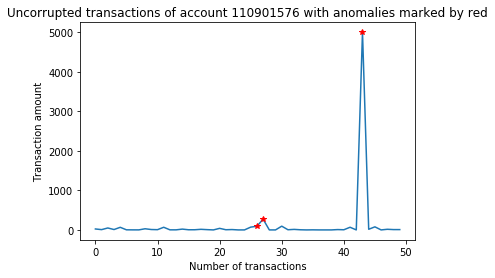

In [13]:
account = '110901576'
plt.plot(amount_dict[account]) # print all the transactions 
plt.title('Uncorrupted transactions of account '+account+' with anomalies marked by red')
plt.xlabel('Number of transactions')
plt.ylabel('Transaction amount')
if account in anomaly_dict: # if the account has anomalies, mark them by red points
    for i in range(len(anomaly_dict[account])):
        plt.plot(anomaly_dict[account][i], amount_dict[account][anomaly_dict[account][i]], 'r*')